## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import BaggingClassifier

## Extracting the `diabetes.csv` file

In [3]:
!unzip /content/archive.zip -d /content/

Archive:  /content/archive.zip
  inflating: /content/diabetes.csv   


In [4]:
# Load & display
df = pd.read_csv('diabetes.csv')

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std    

## Pre-processing and preparation

In [5]:
# Replace 0 with NaN in relevant columns
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

# Impute the missing values with mean
df.fillna(df.mean(), inplace=True)

In [6]:
# Standardise the features
scaler = StandardScaler()
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_scaled = scaler.fit_transform(X)

In [8]:
# Split data (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Dataset visualisation

### Distribution of features

Original data distribution:


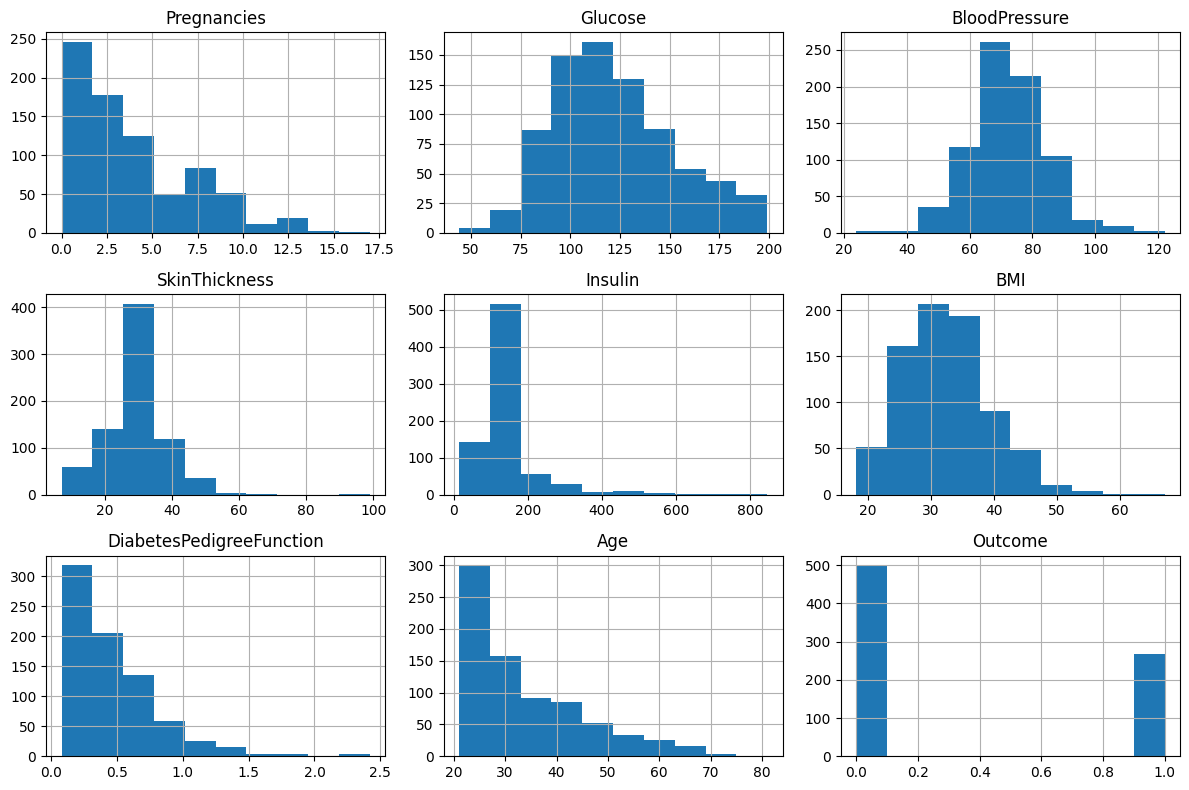

Scaled data distribution:


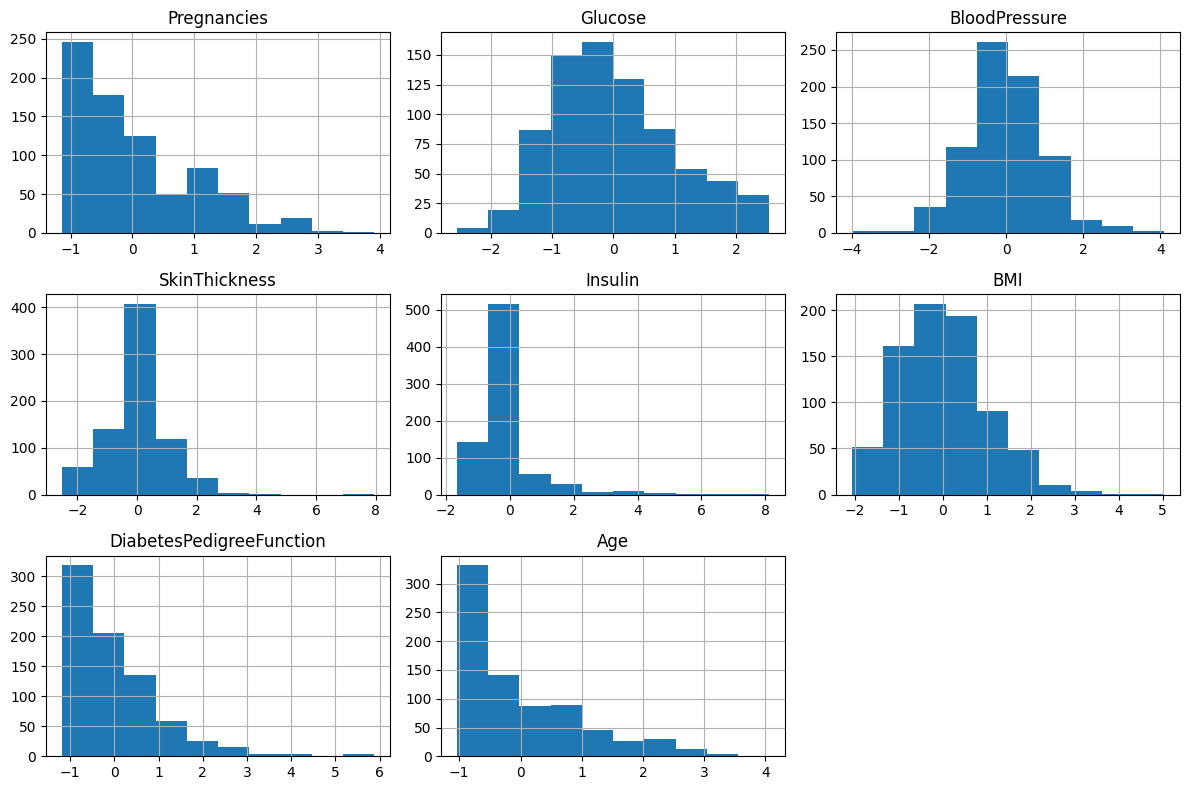

In [10]:
# Visualise original data distribution
print("Original data distribution:")
df.hist(bins=10, figsize=(12, 8))
plt.tight_layout()
plt.show()

# After scaling
print("Scaled data distribution:")
scaled_df = pd.DataFrame(X_scaled, columns=df.columns[:-1])
scaled_df.hist(bins=10, figsize=(12, 8))
plt.tight_layout()
plt.show()

### Correlation heatmap

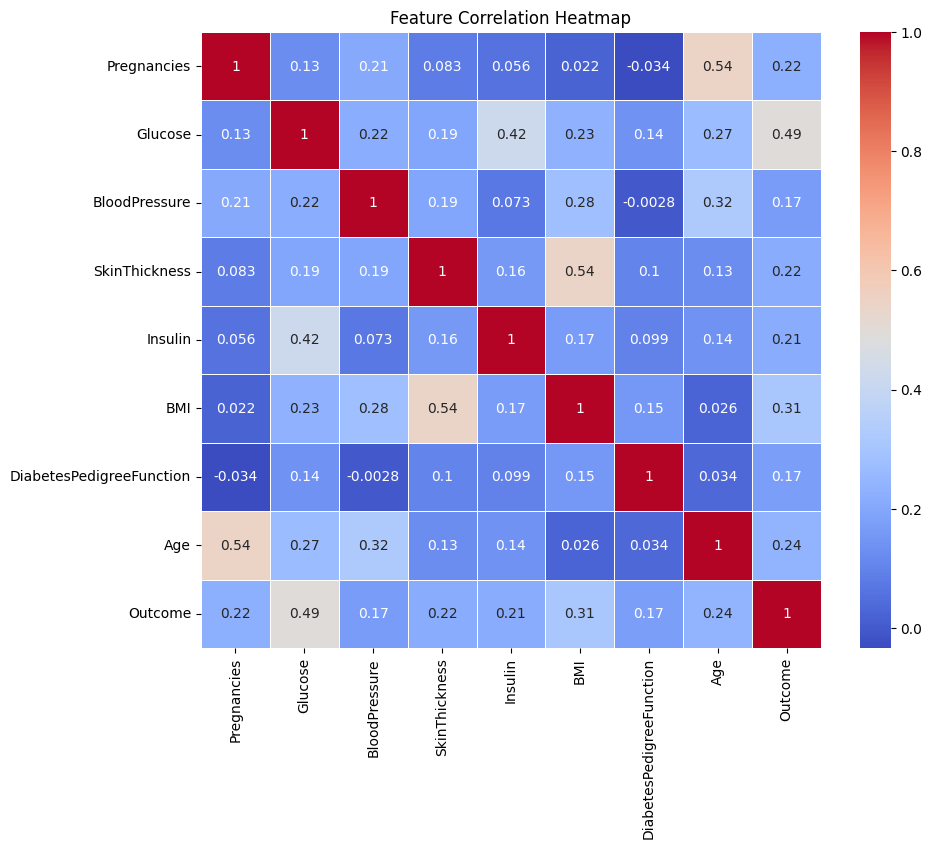

In [11]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


### Outcome distribution (non-diabetic [0] vs. diabetic [1])

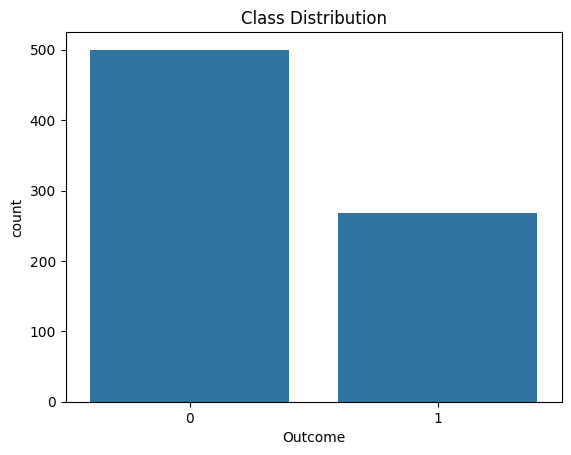

In [13]:
# Outcome distribution
sns.countplot(x='Outcome', data=df)
plt.title('Class Distribution')
plt.show()

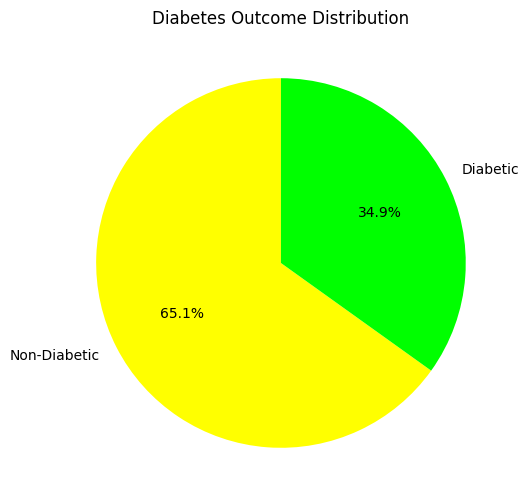

In [19]:
# Outcome class distribution
outcome_counts = df['Outcome'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(outcome_counts, labels=['Non-Diabetic', 'Diabetic'], autopct='%1.1f%%', startangle=90, colors=['yellow', 'lime'])
plt.title('Diabetes Outcome Distribution')
plt.show()

### Pair-plot

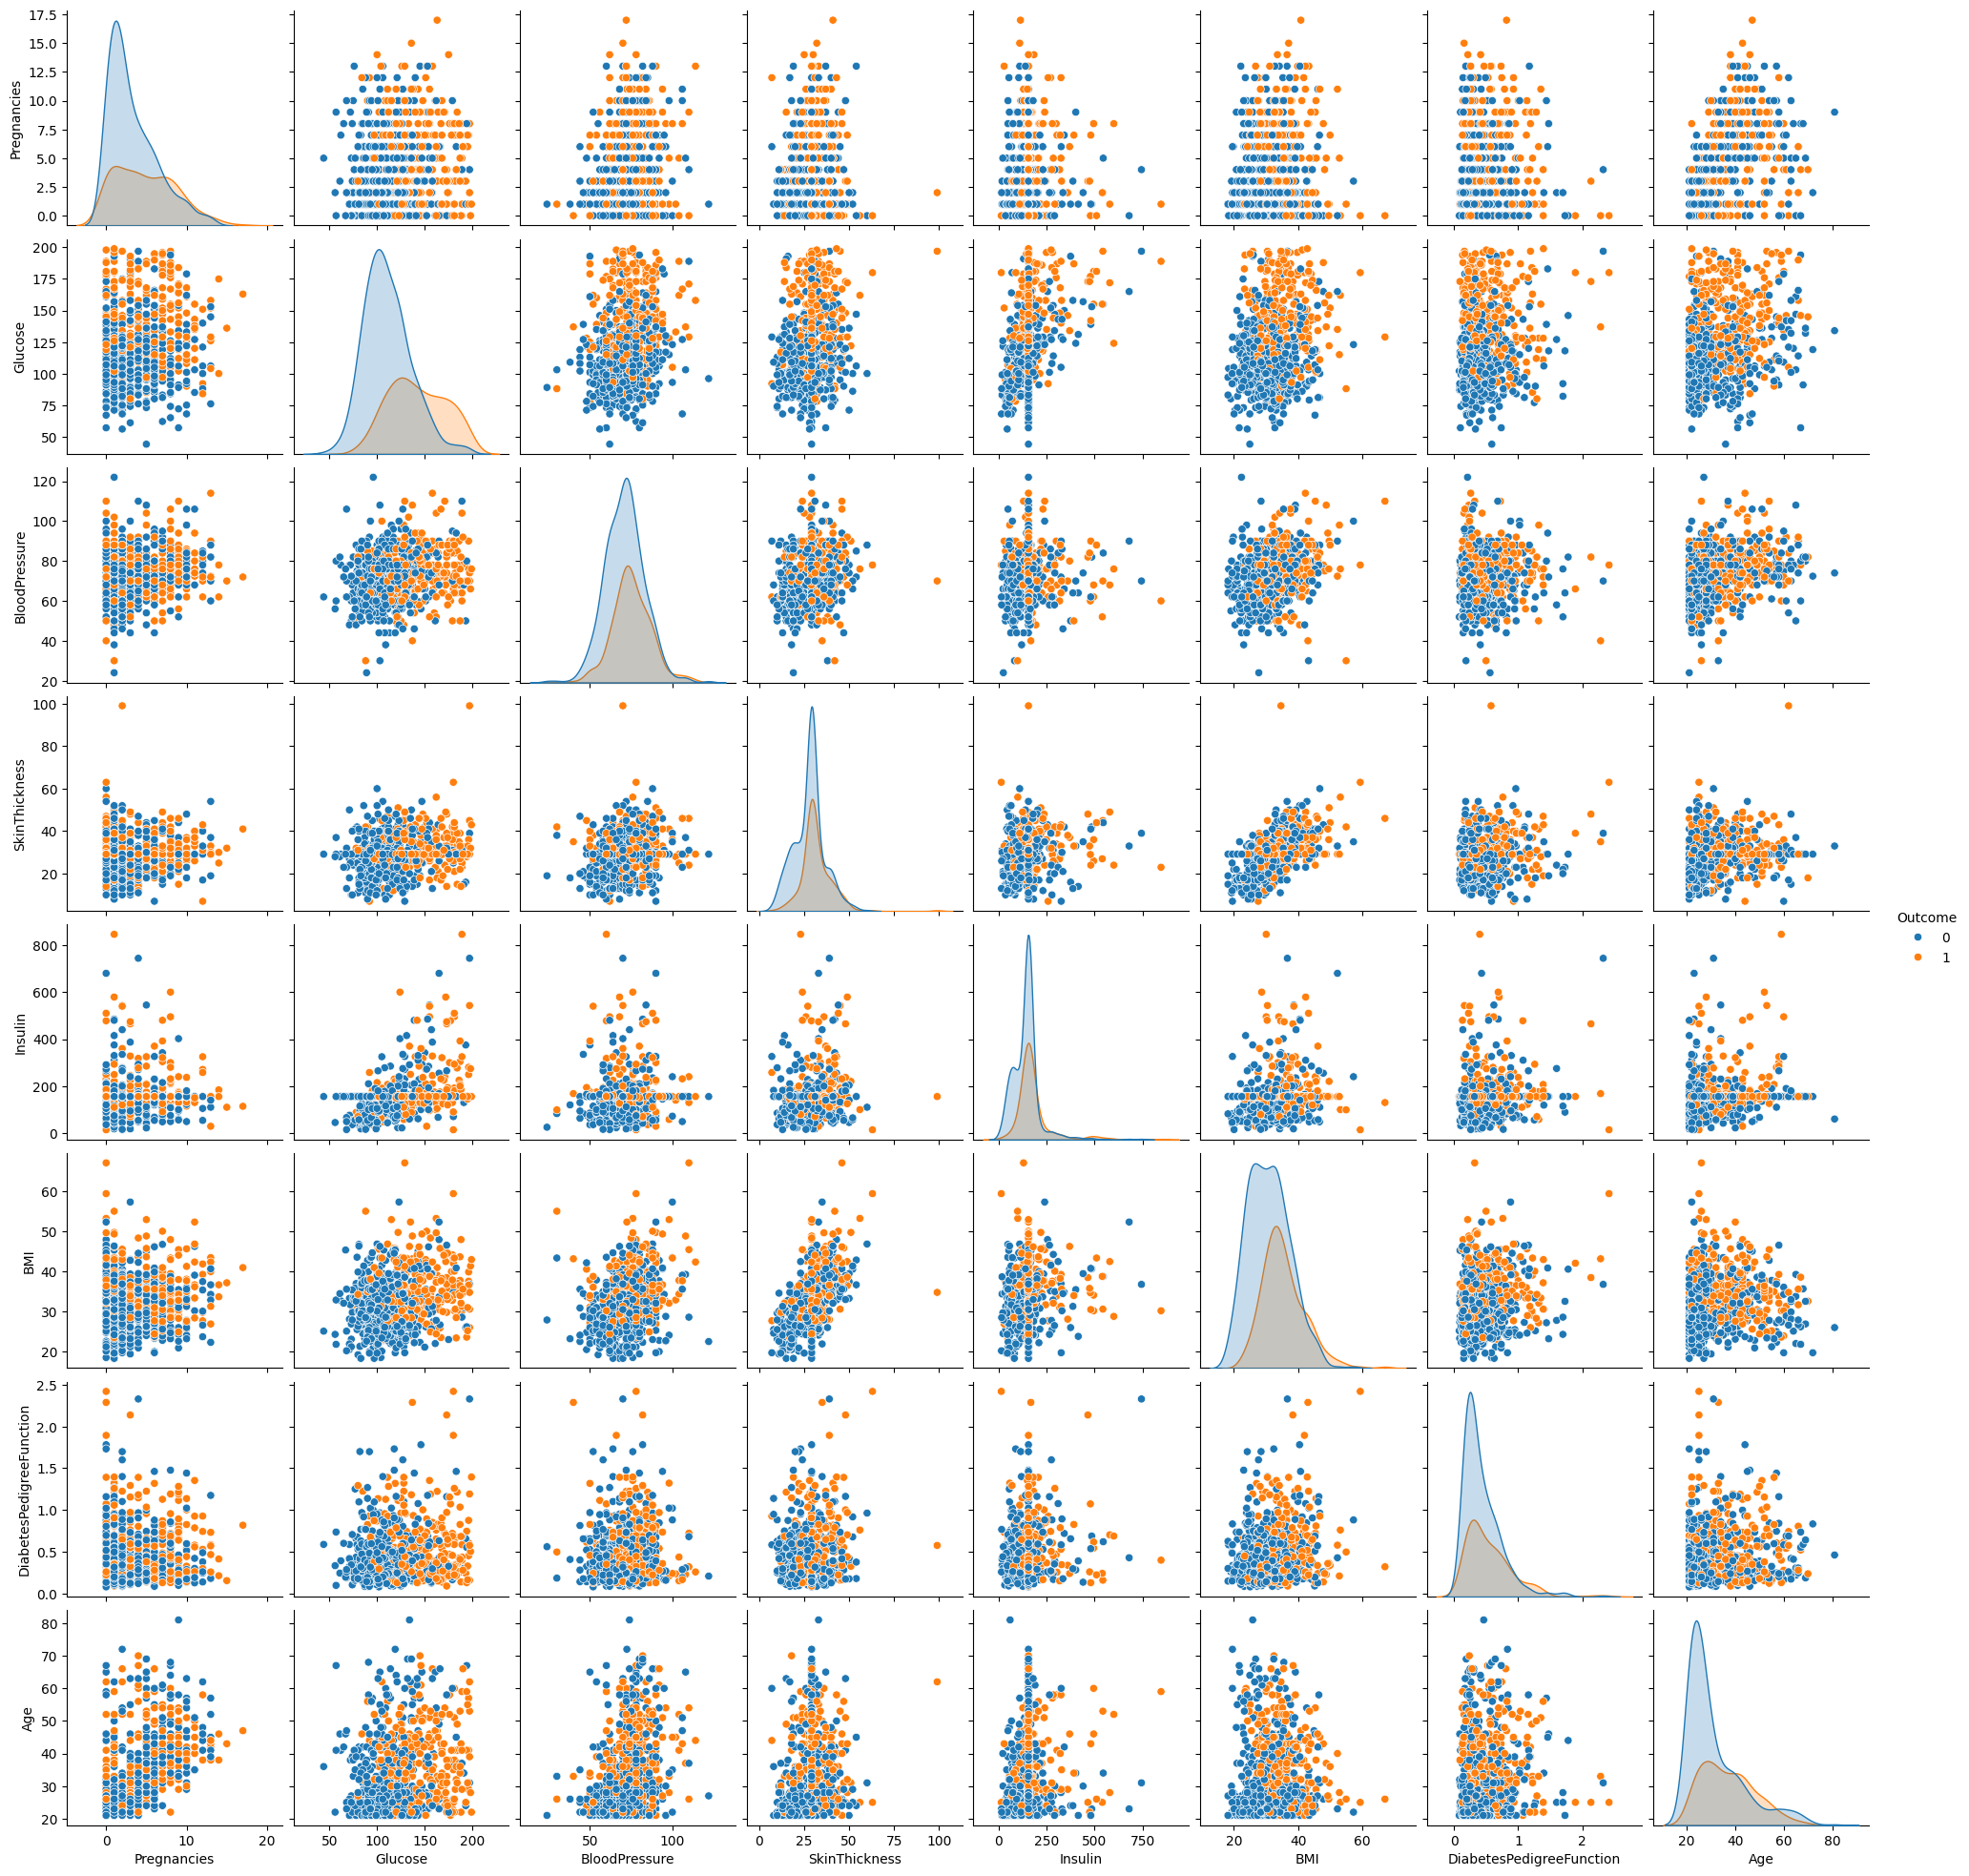

In [15]:
# Pair plot (hue based on Outcome)
sns.pairplot(df, hue="Outcome", diag_kind="kde")
plt.show()


### Box-plots

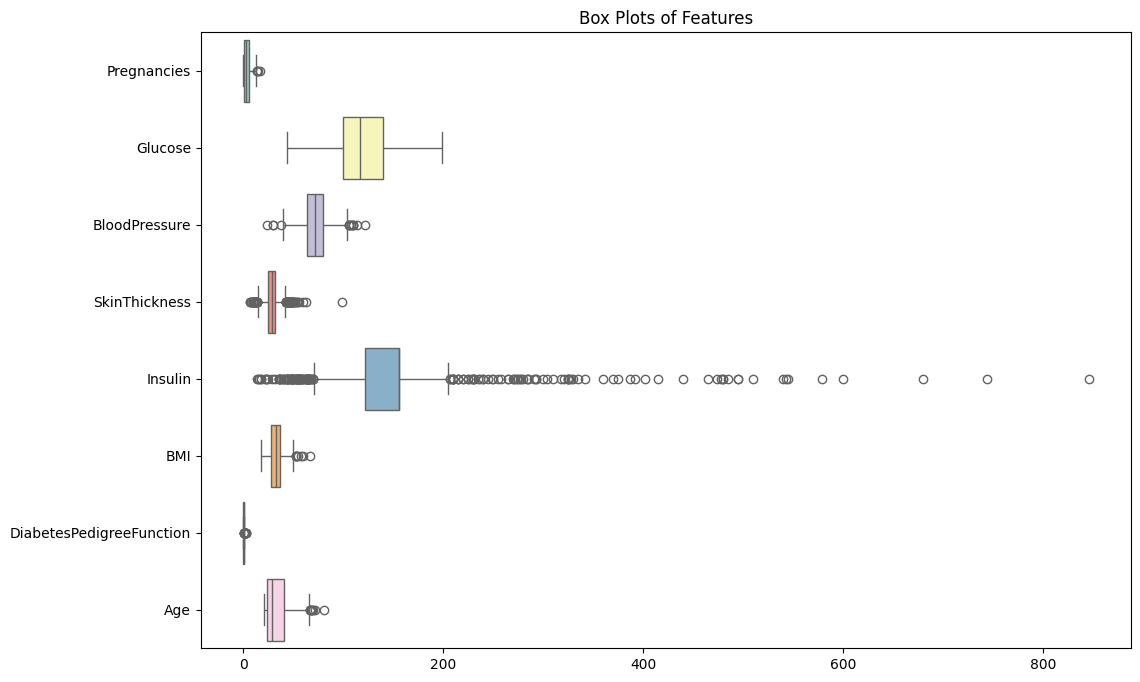

In [20]:
# Box plots (check for outliers and distribution)
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.drop('Outcome', axis=1), orient='h', palette="Set3")
plt.title('Box Plots of Features')
plt.show()

## Baseline model using a single layer perceptron

### Defining the model

In [21]:
# Initialise
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=42)

# Train
perceptron.fit(X_train, y_train)

# Make predictions on test set
y_pred = perceptron.predict(X_test)

### Evaluations

In [22]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 65.58%


In [23]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74        99
           1       0.52      0.44      0.48        55

    accuracy                           0.66       154
   macro avg       0.62      0.61      0.61       154
weighted avg       0.64      0.66      0.65       154



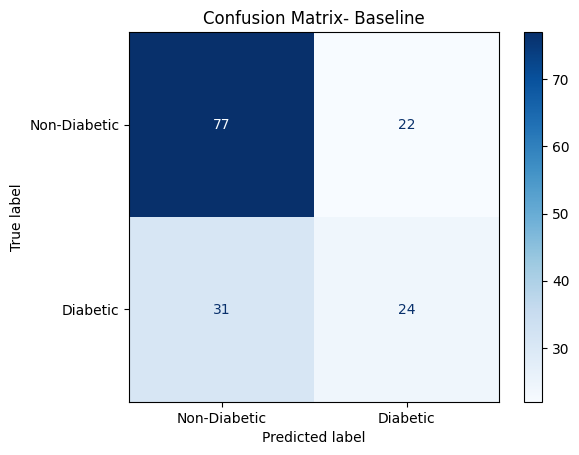

In [44]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Non-Diabetic', 'Diabetic']).plot(cmap='Blues')
plt.title('Confusion Matrix- Baseline')
plt.show()

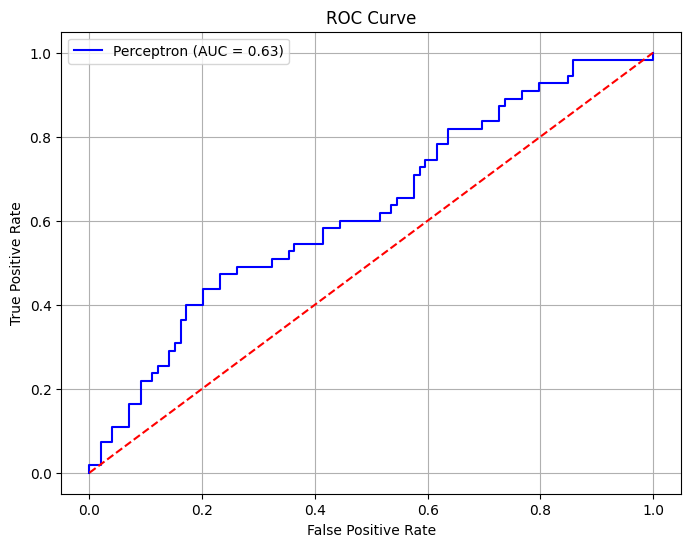

In [25]:
# Calculate ROC curve and AUC score
y_prob = perceptron.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Perceptron (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


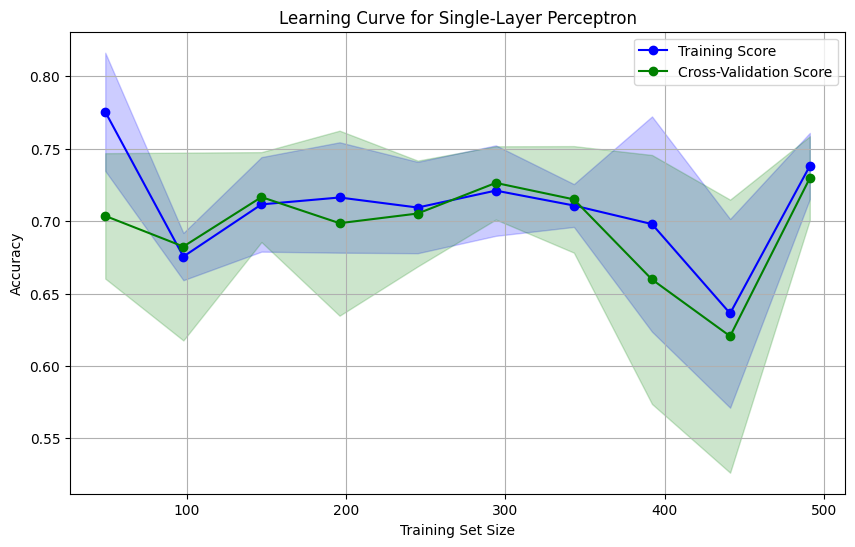

In [26]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(perceptron, X_train, y_train, cv=5, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Calculate mean and std for train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)

plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-Validation Score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

plt.title('Learning Curve for Single-Layer Perceptron')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.grid()
plt.show()

## Fine-tuning baseline hyperparameters using `GridSerachCV`

### Defining the model

In [39]:
# Define hyperparameter grid
param_grid = {
    'penalty': ['l2', 'elasticnet'],
    'alpha': [0.005, 0.01, 0.02],
    'max_iter': [1500, 2000, 2500],
    'eta0': [0.01, 0.05, 0.07],
    'early_stopping': [True],
    'validation_fraction': [0.1, 0.15],
    'n_iter_no_change': [5, 10],
    'class_weight': ['balanced']
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(Perceptron(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters found: {'alpha': 0.005, 'class_weight': 'balanced', 'early_stopping': True, 'eta0': 0.05, 'max_iter': 1500, 'n_iter_no_change': 10, 'penalty': 'elasticnet', 'validation_fraction': 0.15}
Best cross-validation accuracy: 0.7166600026656005


In [40]:
# Get best estimator
best_perceptron = grid_search.best_estimator_

# Make predictions on the test set
y_pred_tuned = best_perceptron.predict(X_test)

### Evaluations

In [41]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_tuned)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 68.18%


In [42]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.62      0.71        99
           1       0.54      0.80      0.64        55

    accuracy                           0.68       154
   macro avg       0.69      0.71      0.68       154
weighted avg       0.74      0.68      0.69       154



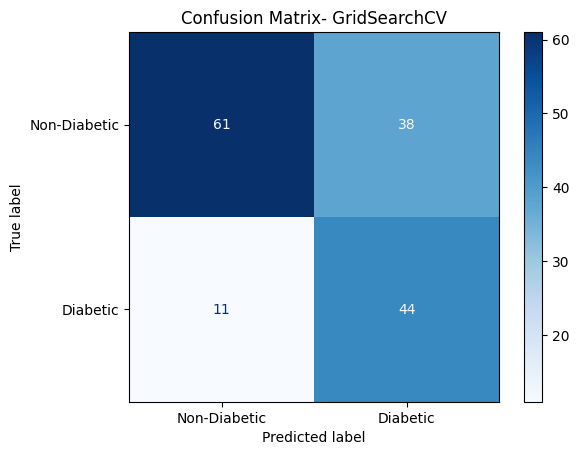

In [45]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned)
ConfusionMatrixDisplay(cm, display_labels=['Non-Diabetic', 'Diabetic']).plot(cmap='Blues')
plt.title('Confusion Matrix- GridSearchCV')
plt.show()

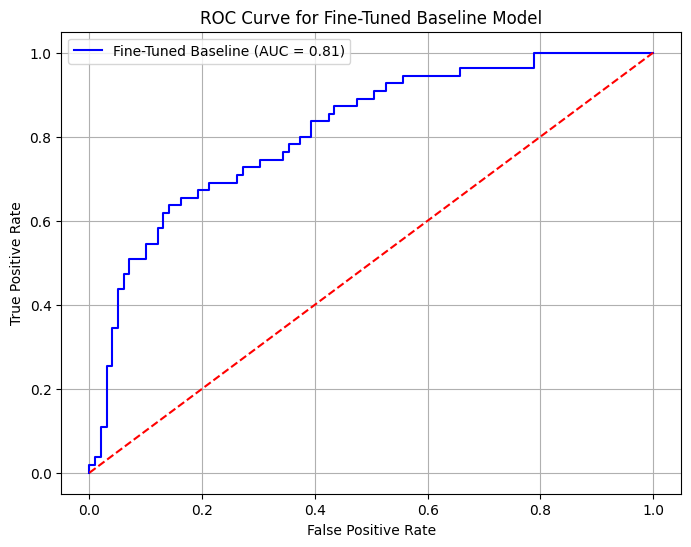

In [64]:
# Calculate ROC curve and AUC score
y_prob_fine_tuned = best_perceptron.decision_function(X_test)
fpr_fine_tuned, tpr_fine_tuned, thresholds_fine_tuned = roc_curve(y_test, y_prob_fine_tuned)
auc_score_fine_tuned = roc_auc_score(y_test, y_prob_fine_tuned)

# Plot
plt.figure(figsize=(8, 6))

plt.plot(fpr_fine_tuned, tpr_fine_tuned, color='blue', label=f'Fine-Tuned Baseline (AUC = {auc_score_fine_tuned:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve for Fine-Tuned Baseline Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

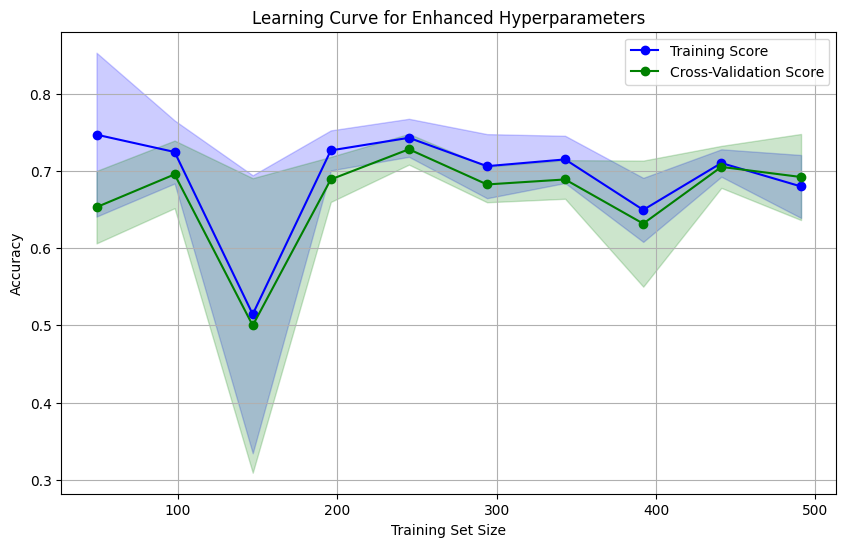

In [47]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(best_perceptron, X_train, y_train, cv=5, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Calculate mean and std for train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)

plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-Validation Score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

plt.title('Learning Curve for Enhanced Hyperparameters')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.grid()
plt.show()

## Using a multi-layer perceptron

### Defining model

In [48]:
# Define pipeline to scale data and apply MLP
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=42, max_iter=1000))
])

# Define hyperparameter grid for MLPClassifier
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01],
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(mlp_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters found: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate_init': 0.001}
Best cross-validation accuracy: 0.7817273090763693


In [49]:
# Make predictions on test set with fine-tuned MLP
best_mlp = grid_search.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)

### Evaluations

In [50]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_mlp)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 75.32%


In [51]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80        99
           1       0.64      0.71      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.74       154
weighted avg       0.76      0.75      0.76       154



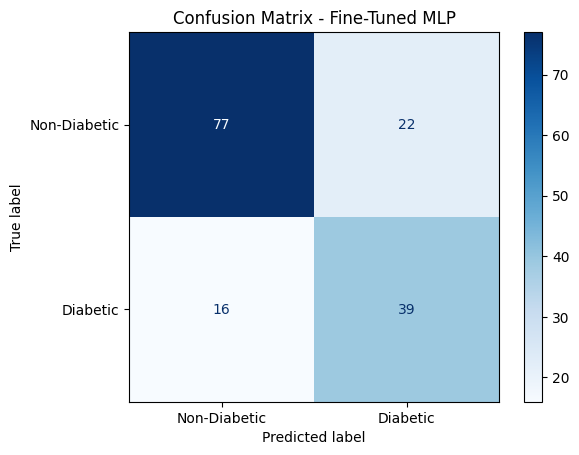

In [52]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
ConfusionMatrixDisplay(cm, display_labels=['Non-Diabetic', 'Diabetic']).plot(cmap='Blues')
plt.title('Confusion Matrix - Fine-Tuned MLP')
plt.show()

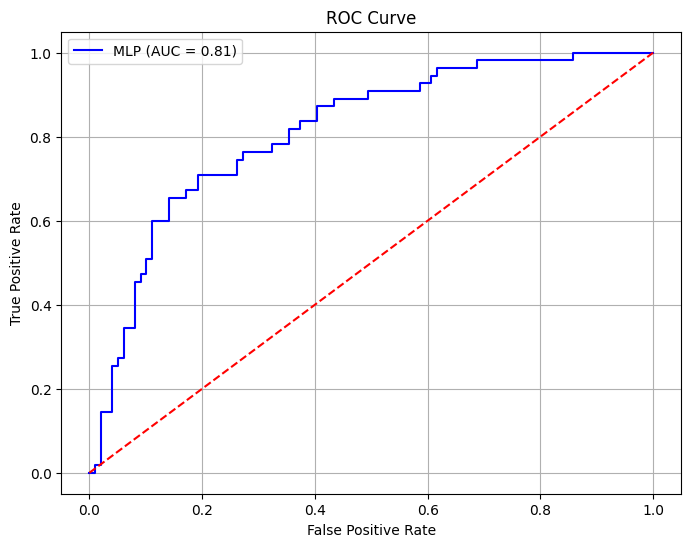

In [59]:
# Calculate ROC curve and AUC score
y_prob_mlp = best_mlp.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_prob_mlp)
auc_score_mlp = roc_auc_score(y_test, y_prob_mlp)

# Plot
plt.figure(figsize=(8, 6))

plt.plot(fpr_mlp, tpr_mlp, color='blue', label=f'MLP (AUC = {auc_score_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

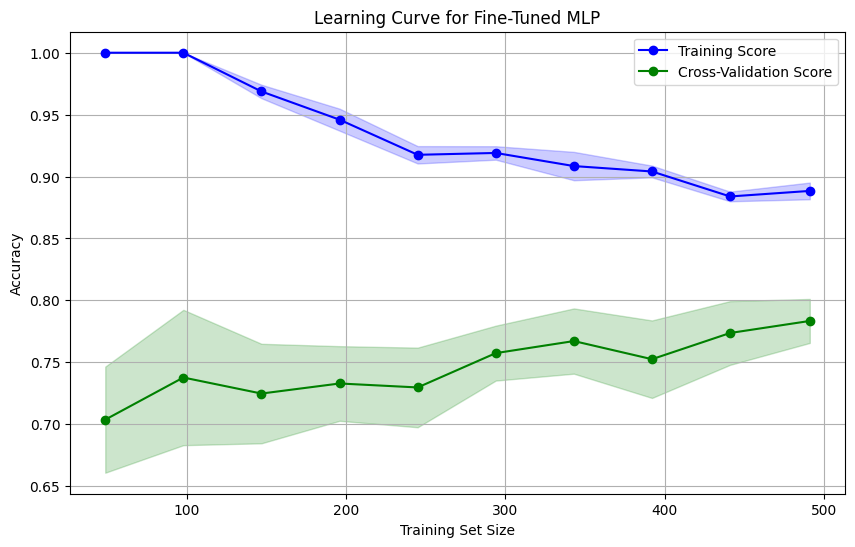

In [53]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(best_mlp, X_train, y_train, cv=5, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Calculate mean and std for train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)

plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-Validation Score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

plt.title('Learning Curve for Fine-Tuned MLP')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.grid()
plt.show()

## Kernel perceptron using bagging

### Defining model

In [68]:
# Define pipeline with Kernel Perceptron
def create_kernel_perceptron_pipeline(gamma, alpha, penalty, n_components):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('feature_map', RBFSampler(gamma=gamma, n_components=n_components, random_state=42)),
        ('perceptron', Perceptron(max_iter=1000, alpha=alpha, penalty=penalty, random_state=42))
    ])

# Parameter grid for GridSearchCV
param_grid = {
    'base_estimator__feature_map__gamma': [0.1, 0.5, 1, 2, 5],
    'base_estimator__feature_map__n_components': [50, 100, 200],
    'base_estimator__perceptron__alpha': [0.0001, 0.001, 0.01, 0.1],
    'base_estimator__perceptron__penalty': [None, 'l2'],
    'n_estimators': [10, 20, 30, 50]  # Increase the number of estimators
}

# Define model using BaggingClassifier with Kernel Perceptron as base estimator
model = BaggingClassifier(
    base_estimator=create_kernel_perceptron_pipeline(gamma=1, alpha=0.001, penalty=None, n_components=100),
    random_state=42
)

# Define StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Fit Grid Search to find best parameters
grid_search.fit(X_train, y_train)

# Get the best model, predict, and evaluate
bagging_kernel = grid_search.best_estimator_

y_pred_bag = bagging_kernel.predict(X_test)
y_prob_bag = bagging_kernel.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


### Evaluations

In [69]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_bag)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 74.68%


In [70]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_bag))

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80        99
           1       0.64      0.67      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



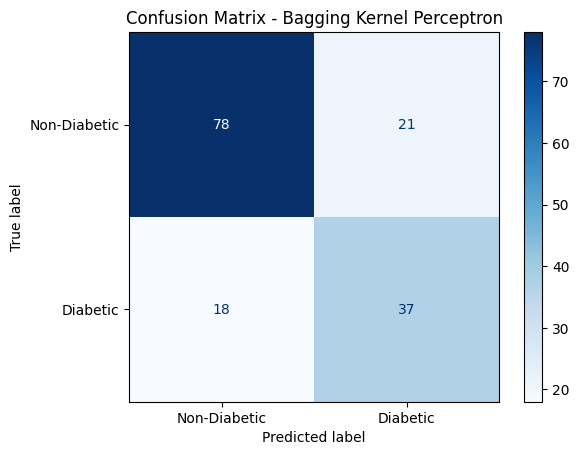

In [71]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_bag)
ConfusionMatrixDisplay(cm, display_labels=['Non-Diabetic', 'Diabetic']).plot(cmap='Blues')
plt.title('Confusion Matrix - Bagging Kernel Perceptron')
plt.show()

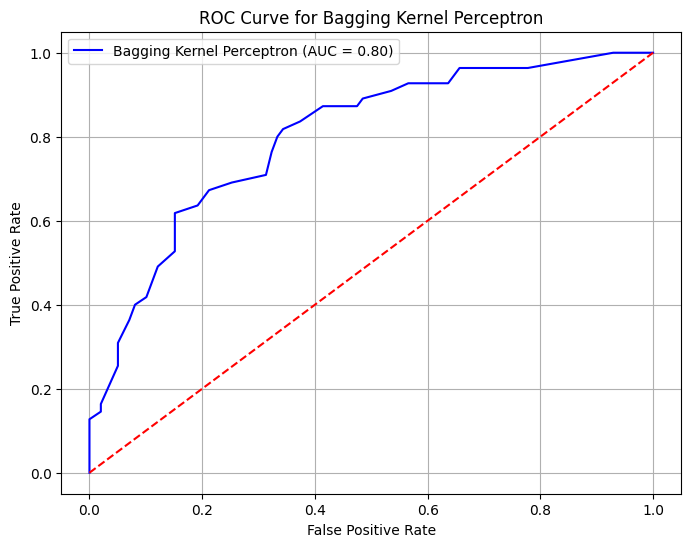

In [74]:
# ROC Curve
fpr_bag, tpr_bag, _ = roc_curve(y_test, y_prob_bag)
auc_score_bag = roc_auc_score(y_test, y_prob_bag)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_bag, tpr_bag, color='blue', label=f'Bagging Kernel Perceptron (AUC = {auc_score_bag:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve for Bagging Kernel Perceptron')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

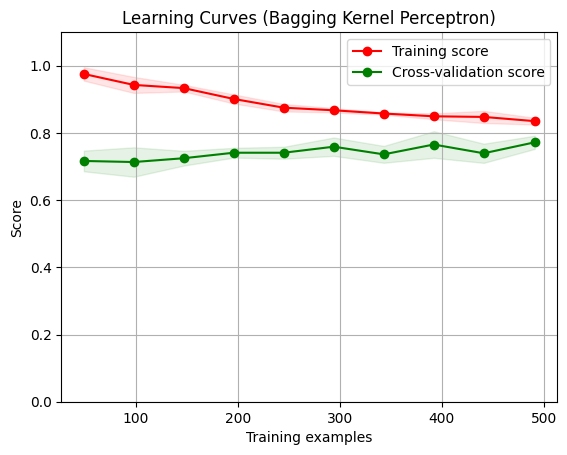

In [76]:
# Plot Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    bagging_kernel, X_train, y_train, cv=cv,
    scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curves (Bagging Kernel Perceptron)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()